In [1]:
#from IPython.core.display import clear_output

#!pip3 install pandas-profiling==2.11
#clear_output()

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#! cp /content/drive/MyDrive/semester7/Thesis/Models/* ./ -r
#! cp /content/drive/MyDrive/semester7/Thesis/Datasets/* ./ -r

In [3]:
#!gdown 1YHqgEFHoXa5vpSfKteAhBUWsJJ2RHgS7 -O data.csv

In [4]:
cd ..

/home/danil-pass123/Desctop/semester7/Thesis/Model_stage5_after_session _stage2


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_regression
from pandas_profiling import ProfileReport

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import minmax_scale

from Datasets.ProcessDataset import Dataset

import torch
from sklearn.model_selection import train_test_split

#from Models.LogisticRegression.LogisticRegression import Logistic_Regression
#from Models.LogisticRegression.LogisticRegression_layer import Logistic_Regression_train
from Models.LogisticRegression.LogisticRegression_numpy import Logistic_Regression_numpy
from Models.LogisticRegression.LogisticRegression_sklearn import Logistic_Regression_origin

from Models.FederatedLearning.Server import server
from Models.FederatedLearning.Worker import worker

from Models.MatrixScheduler.MatrixScheduler_identical import MatrixScheduler_identical
from Models.MatrixScheduler.MatrixScheduler_Uniform import MatrixScheduler_Uniform
from Models.MatrixScheduler.MatrixScheduler_Uniform import CommonMatrixScheduler_Uniform
#from Models.MatrixScheduler.MatrixScheduler_k import MatrixScheduler_k
#from Models.MatrixScheduler.MatrixScheduler_k_array import MatrixScheduler_k_array

from Models.StatisticClass import Statistic
from Models.StatisticClass import comparsion_array_loss,comparsion_array_weights,comparsion_array_acc

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LinearRegression


from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [6]:
import random
random.seed(42)

# load Dataset

In [7]:
data = Dataset(dataset_name = 'Titanic')
X,y = data.X,data.y

In [8]:
cd Reports

/home/danil-pass123/Desctop/semester7/Thesis/Model_stage5_after_session _stage2/Reports


# Classification Model

In [9]:
#X = d_class
#y = y_class
X_train, X_test, y_train, y_test  = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
#X_train,y_train,X_test,y_test = torch.tensor(X_train),torch.tensor(y_train),torch.tensor(X_test),torch.tensor(y_test)

# Federated learning

## Предыдущие модели

### Logistic regression

In [10]:
LR_EPOCH = {"lr":1e-2,"epoch":1000}

#### Model original

In [11]:
LR_EPOCH

{'lr': 0.01, 'epoch': 1000}

In [12]:
stat_origin = Statistic(X_test,y_test,"sklearn model")
log_regr = Logistic_Regression_origin(stat_collector=stat_origin,lr = LR_EPOCH['lr'],epoch = LR_EPOCH['epoch'])

log_regr.train(X_train,y_train)

#### Model numpy

In [13]:
LR_EPOCH

{'lr': 0.01, 'epoch': 1000}

In [14]:
stat_np = Statistic(X_test,y_test,"numpy model")
log_regr_n = Logistic_Regression_numpy(n_features = X_train.shape[1],lr = LR_EPOCH['lr'],
                                       epoch = LR_EPOCH['epoch'],stat_collector=stat_np)
log_regr_n.train(X_train,y_train)

### Федеративные модели

In [15]:
#M_NAMES = ["Logistic_Regression_train", "Logistic_Regression","Logistic_Regression_numpy"]
M_NAMES = "Logistic_Regression_numpy"

In [16]:
LR_EPOCH = {'lr': 0.01, 'epoch': 1000}

In [17]:
model_name = M_NAMES#[2]
model_params = {"lr":LR_EPOCH['lr']}
model_name, model_params

('Logistic_Regression_numpy', {'lr': 0.01})

#### with no scheduler Scheduler

In [18]:
schedulers = [None]
federated_stat_collectors = [Statistic(X_test,y_test,"worker")]

s = server(f_model_name = model_name,stat_collectors = federated_stat_collectors,
           model_params = model_params,
           M_workers=1,
           X_train = X_train,y_train = y_train,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=1)

#### with Scheduler Scheduler

In [19]:
schedulers = [MatrixScheduler_identical()]
federated_sch_stat_collectors = [Statistic(X_test,y_test,"worker1_scheduler")]

s = server(f_model_name = model_name,model_params = model_params,
           stat_collectors = federated_sch_stat_collectors, M_workers=1,
           X_train = X_train,y_train = y_train,
           data_splitter = 'id',m_scheduler = schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=1)

## Example 2 identical

### with no scheduler

In [20]:
schedulers = [None,None,None]
federated_stat_collectors_ident = [Statistic(X_test,y_test,"worker1"),
                                   Statistic(X_test,y_test,"worker2"),
                                   Statistic(X_test,y_test,"worker3")]

s = server(f_model_name = model_name,model_params = model_params,
           M_workers=3,stat_collectors = federated_stat_collectors_ident,
           X_train = X_train,y_train = y_train,data_splitter = "id",m_scheduler=schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

In [21]:
#comparsion_array_loss([federated_stat_collectors_ident[0],
#                       federated_stat_collectors_ident[1],
#                       federated_stat_collectors_ident[2],stat_np,stat_origin])

### with scheduler

In [22]:
schedulers = [MatrixScheduler_identical(),MatrixScheduler_identical(),MatrixScheduler_identical()]
federated_stat_collector_sch_ident = [Statistic(X_test,y_test,"worker1_sch:ident"),
                                      Statistic(X_test,y_test,"worker2_sch:ident"),
                                      Statistic(X_test,y_test,"worker3_sch:ident")]

s = server(f_model_name = model_name,model_params = model_params,
           M_workers=3,stat_collectors = federated_stat_collector_sch_ident,
           X_train = X_train,y_train = y_train,data_splitter = "id",m_scheduler=schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

worker1_sch:ident
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
difference(worker1_sch:ident,worker1) = worker1_sch:ident - worker1


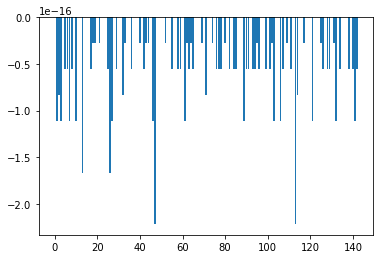

MSE(worker1_sch:ident,worker1) = 4.7662065272790944e-18


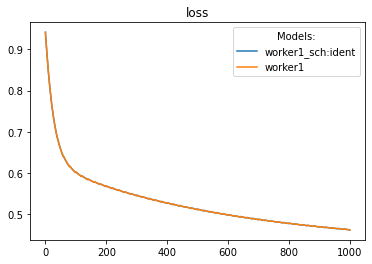

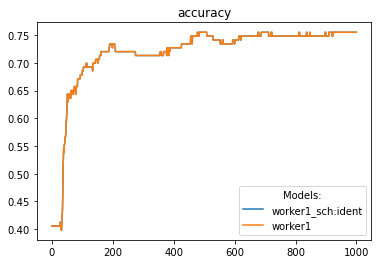

In [23]:
print(federated_stat_collector_sch_ident[0].lable)
print(federated_stat_collector_sch_ident[0].data_description)

federated_stat_collector_sch_ident[0].c_matrix
federated_stat_collector_sch_ident[0].print_accuracy()


federated_stat_collector_sch_ident[0].comparison_mse(federated_stat_collectors_ident[0])
federated_stat_collector_sch_ident[0].comparison_loss_plot(federated_stat_collectors_ident[0])
federated_stat_collector_sch_ident[0].comparison_accuracy_plot(federated_stat_collectors_ident[0])

#federated_stat_collector_sch_ident[0].show_y_distr()

#federated_stat_collector_sch_ident[0].der_mean_plot()

#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].estimated_der,label="est")
#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].derivative_mean,label="der")
#plt.legend()
#plt.show()

worker2_sch:ident
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
difference(worker2_sch:ident,worker2) = worker2_sch:ident - worker2


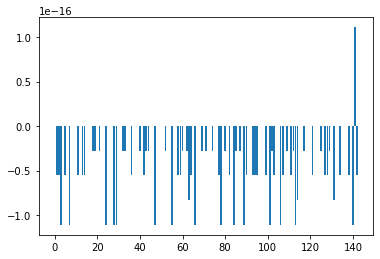

MSE(worker2_sch:ident,worker2) = 3.949247678953438e-18


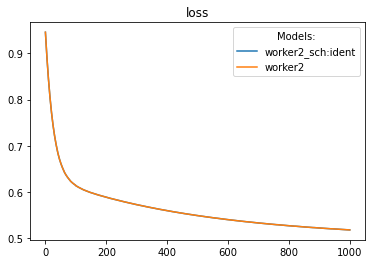

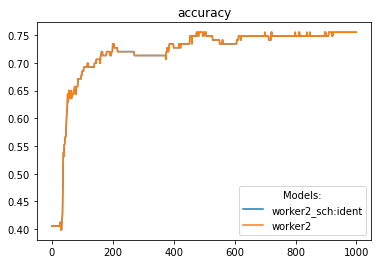

In [24]:
print(federated_stat_collector_sch_ident[1].lable)
print(federated_stat_collector_sch_ident[1].data_description)

federated_stat_collector_sch_ident[1].c_matrix
federated_stat_collector_sch_ident[1].print_accuracy()

federated_stat_collector_sch_ident[1].comparison_mse(federated_stat_collectors_ident[1])
federated_stat_collector_sch_ident[1].comparison_loss_plot(federated_stat_collectors_ident[1])
federated_stat_collector_sch_ident[1].comparison_accuracy_plot(federated_stat_collectors_ident[1])

#federated_stat_collector_sch_ident[0].show_y_distr()

#federated_stat_collector_sch_ident[0].der_mean_plot()

#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].estimated_der,label="est")
#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].derivative_mean,label="der")
#plt.legend()
#plt.show()

worker3_sch:ident
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187
balanced_accuracy_score: 0.7170385395537525
accuracy_score: 0.7482517482517482
difference(worker3_sch:ident,worker3) = worker3_sch:ident - worker3


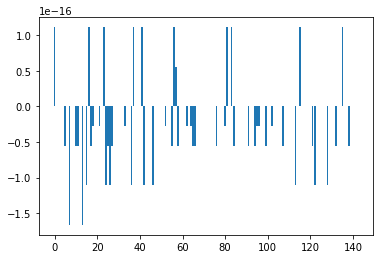

MSE(worker3_sch:ident,worker3) = 4.1899337816153515e-18


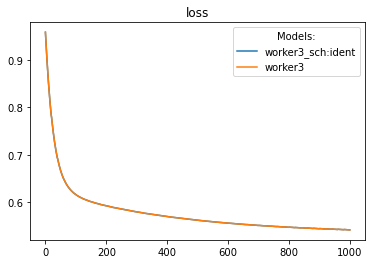

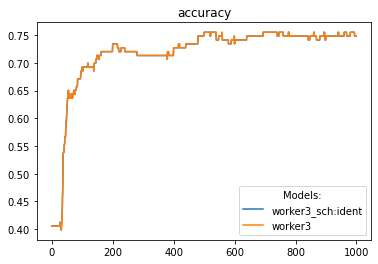

In [25]:
print(federated_stat_collector_sch_ident[2].lable)
print(federated_stat_collector_sch_ident[2].data_description)

federated_stat_collector_sch_ident[2].c_matrix
federated_stat_collector_sch_ident[2].print_accuracy()

federated_stat_collector_sch_ident[2].comparison_mse(federated_stat_collectors_ident[2])
federated_stat_collector_sch_ident[2].comparison_loss_plot(federated_stat_collectors_ident[2])
federated_stat_collector_sch_ident[2].comparison_accuracy_plot(federated_stat_collectors_ident[2])

#federated_stat_collector_sch_ident[0].show_y_distr()

#federated_stat_collector_sch_ident[0].der_mean_plot()

#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].estimated_der,label="est")
#plt.plot(federated_stat_collector_sch_ident[0].iter_list,federated_stat_collector_sch_ident[0].derivative_mean,label="der")
#plt.legend()
#plt.show()

In [26]:
#for i in range(11):
#    federated_stat_collector_sch_ident[0].comparison_weight_plot(federated_stat_collectors_ident[0],i)

### Матрица из равномерного расспределения

In [62]:
scheduler = CommonMatrixScheduler_Uniform(alpha=0.01,gamma=3,
                                      change_mode=CommonMatrixScheduler_Uniform.change_on_each_global_update,n_workers = 3)

schedulers = [scheduler, scheduler, scheduler]
federated_stat_collector_sch_uniform = [Statistic(X_test,y_test,"worker1_sch:uniform"),
                                      Statistic(X_test,y_test,"worker2_sch:uniform"),
                                      Statistic(X_test,y_test,"worker3_sch:uniform")]

s = server(f_model_name = model_name,model_params = model_params,
           M_workers=3,stat_collectors = federated_stat_collector_sch_uniform,
           X_train = X_train,y_train = y_train,data_splitter = "id",m_scheduler=schedulers)

s.run(n_iter=LR_EPOCH['epoch'],T=20)

In [63]:
LR_EPOCH['epoch']/20,len(scheduler.diagonal_values_history)

(50.0, 50)

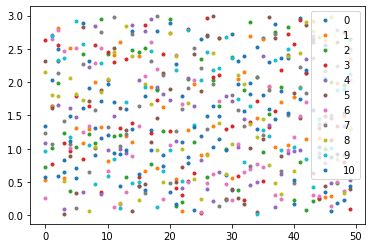

In [64]:
for j in range(11):
    array = []
    for i in range(50):#len(scheduler1[0].diagonal_values_history)):
        array.append(scheduler.diagonal_values_history[i][j])
    plt.plot(np.arange(50),array,'.',label = j)
plt.legend()
plt.show()

Loss, Weigths, Accuracy Plots

worker1_sch:uniform
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191


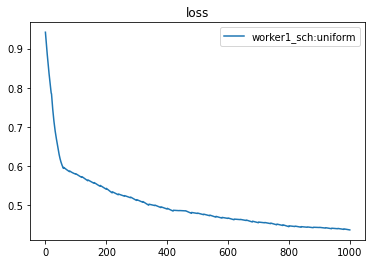

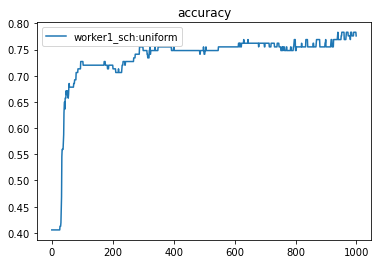

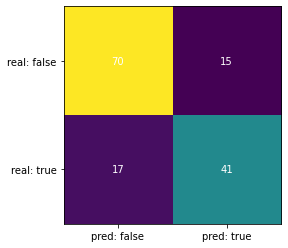

[[70 15]
 [17 41]]
balanced_accuracy_score: 0.7652129817444219
accuracy_score: 0.7762237762237763


In [65]:
current_stat_collector = federated_stat_collector_sch_uniform[0]
print(current_stat_collector.lable)
print(current_stat_collector.data_description)

current_stat_collector.loss_plot()
current_stat_collector.acc_plot()

current_stat_collector.plot_confusion_matrix()
current_stat_collector.print_accuracy()

In [66]:
#current_stat_collector = federated_stat_collector_sch_uniform[0]
#current_stat_collector.show_y_distr()

#current_stat_collector.der_mean_plot()

#plt.plot(current_stat_collector.iter_list,current_stat_collector.estimated_der,label="est")
#plt.plot(current_stat_collector.iter_list,current_stat_collector.derivative_mean,label="der")
#plt.legend()
#plt.show()

worker2_sch:uniform
# of true val: 77 (0.4031413612565445)
# of true val: 114 (0.5968586387434555)
# samples: 191


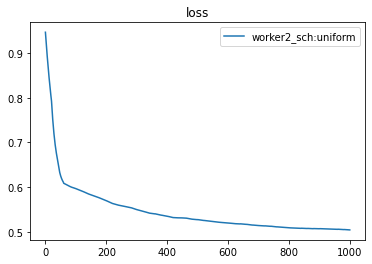

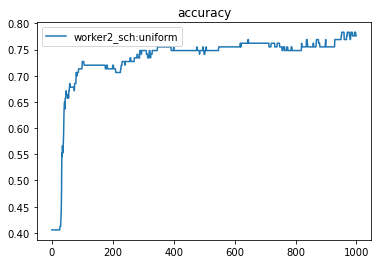

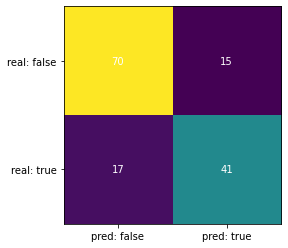

[[70 15]
 [17 41]]
balanced_accuracy_score: 0.7652129817444219
accuracy_score: 0.7762237762237763


In [67]:
current_stat_collector = federated_stat_collector_sch_uniform[1]
print(current_stat_collector.lable)
print(current_stat_collector.data_description)

current_stat_collector.loss_plot()
current_stat_collector.acc_plot()

current_stat_collector.plot_confusion_matrix()
current_stat_collector.print_accuracy()

In [68]:
#current_stat_collector = federated_stat_collector_sch_uniform[1]
#current_stat_collector.show_y_distr()

#current_stat_collector.der_mean_plot()

#plt.plot(current_stat_collector.iter_list,current_stat_collector.estimated_der,label="est")
#plt.plot(current_stat_collector.iter_list,current_stat_collector.derivative_mean,label="der")
#plt.legend()
#plt.show()

worker3_sch:uniform
# of true val: 76 (0.40641711229946526)
# of true val: 111 (0.5935828877005348)
# samples: 187


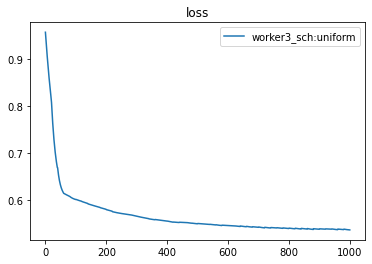

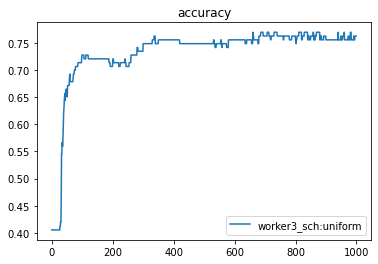

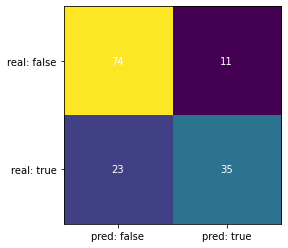

[[74 11]
 [23 35]]
balanced_accuracy_score: 0.7370182555780933
accuracy_score: 0.7622377622377622


In [69]:
current_stat_collector = federated_stat_collector_sch_uniform[2]
print(current_stat_collector.lable)
print(current_stat_collector.data_description)

current_stat_collector.loss_plot()
current_stat_collector.acc_plot()

current_stat_collector.plot_confusion_matrix()
current_stat_collector.print_accuracy()

In [70]:
#current_stat_collector = federated_stat_collector_sch_uniform[2]
#current_stat_collector.show_y_distr()

#current_stat_collector.der_mean_plot()

#plt.plot(current_stat_collector.iter_list,current_stat_collector.estimated_der,label="est")
#plt.plot(current_stat_collector.iter_list,current_stat_collector.derivative_mean,label="der")
#plt.legend()
#plt.show()

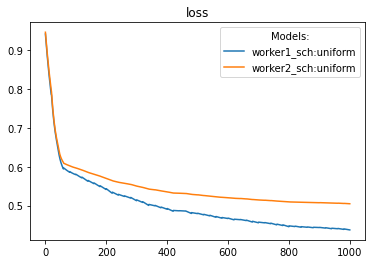

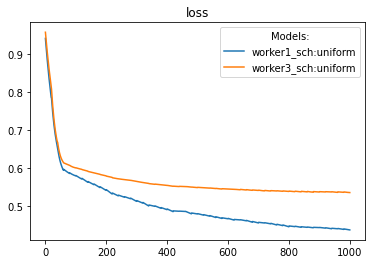

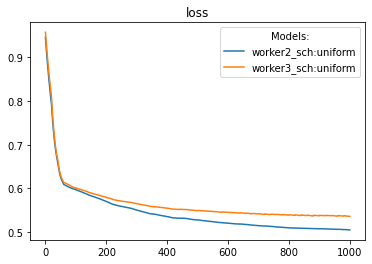

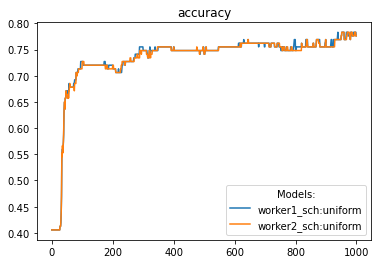

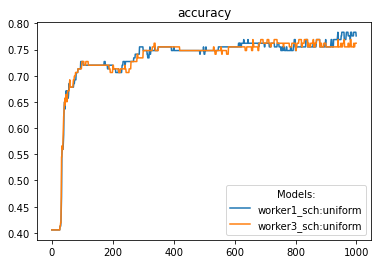

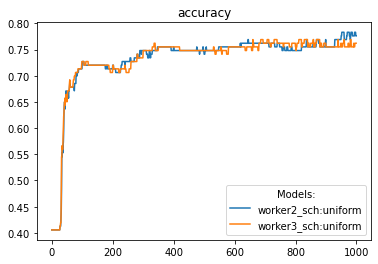

In [71]:
federated_stat_collector_sch_uniform[0].comparison_loss_plot(federated_stat_collector_sch_uniform[1])
federated_stat_collector_sch_uniform[0].comparison_loss_plot(federated_stat_collector_sch_uniform[2])
federated_stat_collector_sch_uniform[1].comparison_loss_plot(federated_stat_collector_sch_uniform[2])

federated_stat_collector_sch_uniform[0].comparison_accuracy_plot(federated_stat_collector_sch_uniform[1])
federated_stat_collector_sch_uniform[0].comparison_accuracy_plot(federated_stat_collector_sch_uniform[2])
federated_stat_collector_sch_uniform[1].comparison_accuracy_plot(federated_stat_collector_sch_uniform[2])

#### сравнение с примером c единичной матрицы (scheduler)

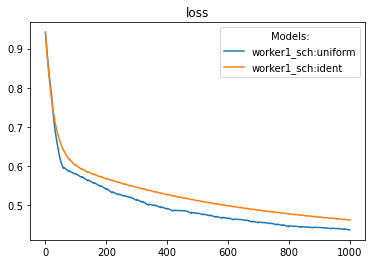

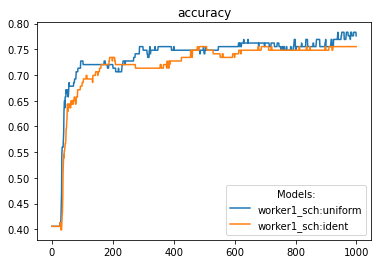

worker1_sch:uniform


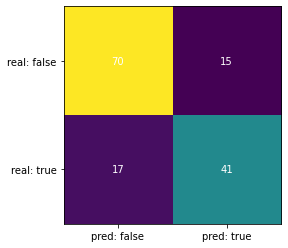

[[70 15]
 [17 41]]
balanced_accuracy_score: 0.7652129817444219
accuracy_score: 0.7762237762237763
worker1_sch:ident


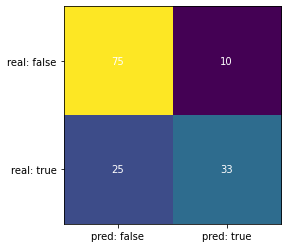

[[75 10]
 [25 33]]
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
difference(worker1_sch:uniform,worker1_sch:ident) = worker1_sch:uniform - worker1_sch:ident


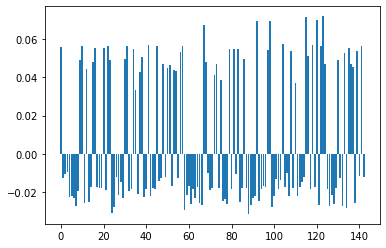

MSE(worker1_sch:uniform,worker1_sch:ident) = 0.0030263029438320987


In [72]:
#stat_np,stat_origin
current_stat_collector_uniform = federated_stat_collector_sch_uniform[0]
current_stat_collector_ident = federated_stat_collector_sch_ident[0]

current_stat_collector_uniform.comparison_loss_plot(current_stat_collector_ident)
current_stat_collector_uniform.comparison_accuracy_plot(current_stat_collector_ident)

print(current_stat_collector_uniform.lable)

current_stat_collector_uniform.plot_confusion_matrix()
current_stat_collector_uniform.print_accuracy()

print(current_stat_collector_ident.lable)
current_stat_collector_ident.plot_confusion_matrix()
current_stat_collector_ident.print_accuracy()

current_stat_collector_uniform.comparison_mse(current_stat_collector_ident)

In [73]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[0]
#current_stat_collector_ident = federated_stat_collector_sch_ident[0]

#current_stat_collector_uniform.comparison_der_mean_plot(current_stat_collector_ident)
#for i in range(11):
#    current_stat_collector_uniform.comparison_der_plot(current_stat_collector_ident,i)

In [74]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[0]
#current_stat_collector_ident = federated_stat_collector_sch_ident[0]

#current_stat_collector_uniform.comparison_weights_plot(current_stat_collector_ident)

#for i in range(11):
#    current_stat_collector_uniform.comparison_weight_plot(current_stat_collector_ident,i)

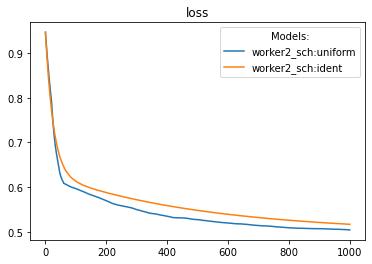

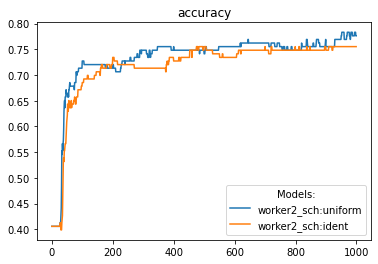

worker2_sch:uniform


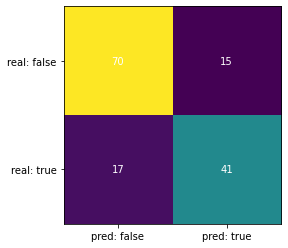

[[70 15]
 [17 41]]
balanced_accuracy_score: 0.7652129817444219
accuracy_score: 0.7762237762237763
worker2_sch:ident


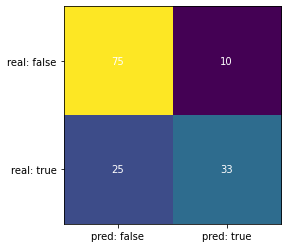

[[75 10]
 [25 33]]
balanced_accuracy_score: 0.725659229208925
accuracy_score: 0.7552447552447552
difference(worker2_sch:uniform,worker2_sch:ident) = worker2_sch:uniform - worker2_sch:ident


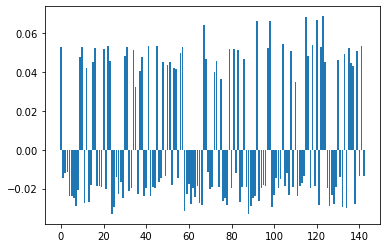

MSE(worker2_sch:uniform,worker2_sch:ident) = 0.002948503681852252


In [75]:
#stat_np,stat_origin
current_stat_collector_uniform = federated_stat_collector_sch_uniform[1]
current_stat_collector_ident = federated_stat_collector_sch_ident[1]

current_stat_collector_uniform.comparison_loss_plot(current_stat_collector_ident)
current_stat_collector_uniform.comparison_accuracy_plot(current_stat_collector_ident)

print(current_stat_collector_uniform.lable)
current_stat_collector_uniform.plot_confusion_matrix()
current_stat_collector_uniform.print_accuracy()

print(current_stat_collector_ident.lable)
current_stat_collector_ident.plot_confusion_matrix()
current_stat_collector_ident.print_accuracy()

current_stat_collector_uniform.comparison_mse(current_stat_collector_ident)

In [76]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[1]
#current_stat_collector_ident = federated_stat_collector_sch_ident[1]

#current_stat_collector_uniform.comparison_der_mean_plot(current_stat_collector_ident)
#for i in range(11):
#    current_stat_collector_uniform.comparison_der_plot(current_stat_collector_ident,i)

In [77]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[1]
#current_stat_collector_ident = federated_stat_collector_sch_ident[1]

#current_stat_collector_uniform.comparison_weights_plot(current_stat_collector_ident)

#for i in range(11):
#    current_stat_collector_uniform.comparison_weight_plot(current_stat_collector_ident,i)

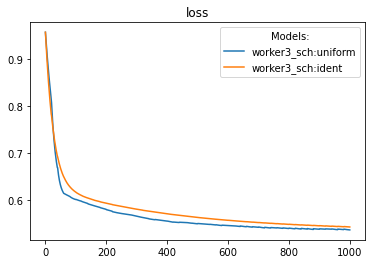

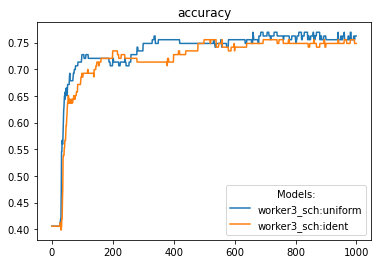

worker3_sch:uniform


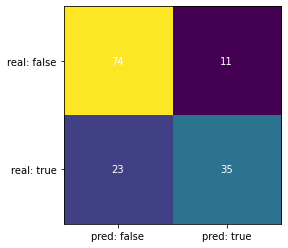

[[74 11]
 [23 35]]
balanced_accuracy_score: 0.7370182555780933
accuracy_score: 0.7622377622377622
worker3_sch:ident


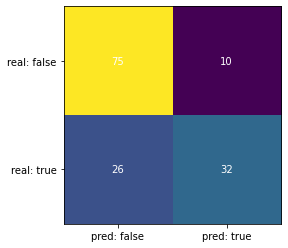

[[75 10]
 [26 32]]
balanced_accuracy_score: 0.7170385395537525
accuracy_score: 0.7482517482517482
difference(worker3_sch:uniform,worker3_sch:ident) = worker3_sch:uniform - worker3_sch:ident


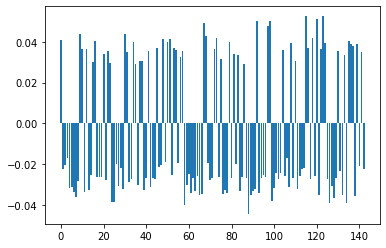

MSE(worker3_sch:uniform,worker3_sch:ident) = 0.002771532082066462


In [78]:
#stat_np,stat_origin
current_stat_collector_uniform = federated_stat_collector_sch_uniform[2]
current_stat_collector_ident = federated_stat_collector_sch_ident[2]

current_stat_collector_uniform.comparison_loss_plot(current_stat_collector_ident)
current_stat_collector_uniform.comparison_accuracy_plot(current_stat_collector_ident)

print(current_stat_collector_uniform.lable)
current_stat_collector_uniform.plot_confusion_matrix()
current_stat_collector_uniform.print_accuracy()

print(current_stat_collector_ident.lable)
current_stat_collector_ident.plot_confusion_matrix()
current_stat_collector_ident.print_accuracy()

current_stat_collector_uniform.comparison_mse(current_stat_collector_ident)

In [82]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[2]
#current_stat_collector_ident = federated_stat_collector_sch_ident[2]

#current_stat_collector_uniform.comparison_der_mean_plot(current_stat_collector_ident)
#for i in range(11):
#    current_stat_collector_uniform.comparison_der_plot(current_stat_collector_ident,i)

In [81]:
#current_stat_collector_uniform = federated_stat_collector_sch_uniform[2]
#current_stat_collector_ident = federated_stat_collector_sch_ident[2]

#current_stat_collector_uniform.comparison_weights_plot(current_stat_collector_ident)

#for i in range(11):
#    current_stat_collector_uniform.comparison_weight_plot(current_stat_collector_ident,i)